# RNN Time Series Forecasting (EUR-USD Financial Dataset example)


## IADS Summer School 2023

### Dr Michael Fairbank, University of Essex, UK

- Email: m.fairbank@essex.ac.uk

## Objective

- We've seen that RNNs can spot arbitrary patterns in data and make predictions from these patterns.

- In this notebook we will use a RNN to forecast the EUR/USD exchange rate.

## Load dataset

We use Pandas to load the csv file very easily in Python.  Pandas also lets us easily manipulate and view the data.

This dataset came from my own Interactive Brokers account.



In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#df0 = pd.read_csv("datasets/eurusd60s_2013_2018.csv.zip", compression='zip', sep=',') # This data is minute-by-minute data.
# If the above line fails then try the following line instead, to download it directly from 
# my google drive account
df0 = pd.read_csv("https://drive.google.com/uc?export=download&id=1o052vfAJRCKcZD2-fLLe-9CBQd-WWhjN", compression='zip', sep=',')

df0 = df0[0::(60)] # Reduce data down to hourly.


Let's take a glance at the data. Here are the first few rows.  


In [3]:
print(df0.head())
print(df0.describe().transpose())


                    date   symbol  vol  bid_open  bid_low  bid_high  ask_open  \
0    2013-01-02 00:00:00  EUR/USD    0   1.31970  1.31925   1.31975   1.31995   
60   2013-01-02 01:00:00  EUR/USD    0   1.32070  1.32065   1.32080   1.32080   
120  2013-01-02 02:00:00  EUR/USD    0   1.32755  1.32725   1.32855   1.32760   
180  2013-01-02 03:00:00  EUR/USD    0   1.32935  1.32935   1.32950   1.32945   
240  2013-01-02 04:00:00  EUR/USD    0   1.32860  1.32835   1.32890   1.32870   

     ask_low  ask_high  
0    1.31940   1.31995  
60   1.32080   1.32085  
120  1.32755   1.32860  
180  1.32940   1.32955  
240  1.32850   1.32905  
            count      mean       std      min      25%      50%       75%  \
vol       36254.0  0.000000  0.000000  0.00000  0.00000  0.00000  0.000000   
bid_open  36254.0  1.197428  0.103198  1.03590  1.11550  1.16565  1.301850   
bid_low   36254.0  1.197325  0.103203  1.03580  1.11535  1.16560  1.301700   
bid_high  36254.0  1.197532  0.103192  1.03595  1.1

- Note the volume data is missing for this Forex data.

- In real trading you buy at the ask prices and sell at the bid prices, so always lose a bit of money due to the difference in any transaction.  Plus there are usually other commission costs and price slippage.  We will only look at bid prices in this exercise.

- The high and low prices for each bar were calculated on the minute-by-minute data so are invalid now we have trucated down to hourly data.  Hence we should only look at open_bid price in this exercise.

## View data graphically

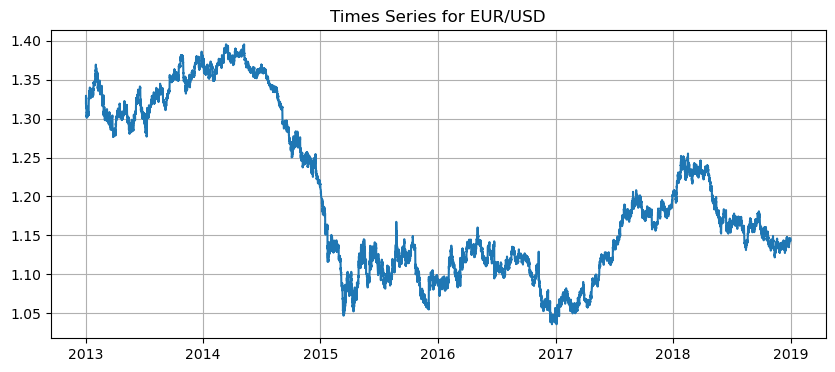

In [4]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 4))
ax = plt.gca()
formatter = mdates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.YearLocator()
ax.xaxis.set_major_locator(locator)
plt.plot(pd.to_datetime(df0['date']), df0['bid_open']) # Only look at one of the price columns (for simplicity)
plt.title('Times Series for EUR/USD');
plt.grid()
plt.show()

## Calculate log returns, and simplify dataset

The log return of a price at time $p_t$ is $log(p_t/p_{t-1})$.  This tells you the ratio that a price has changed by in any one time step.  It will be positive if $p_t>p_{t-1}$ and negative otherwise.

In [5]:
price_col=df0["bid_open"].values
price_return=np.log(price_col[1:]/price_col[:-1])
price_col=price_col[1:]
df=pd.DataFrame(columns=["price","return"], data=np.stack([price_col,price_return],axis=1))
print(df.head())

     price    return
0  1.32070  0.000757
1  1.32755  0.005173
2  1.32935  0.001355
3  1.32860 -0.000564
4  1.32605 -0.001921


## Split the Data

- We'll use a `(70%, 30%)` split for the training and validation. 

- Note, the data is **not** being randomly shuffled before splitting. 

    - We must not shuffle the validation set into the training dataset - that would be cheating ourselves.


In [6]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):n]


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation (and test) sets.


In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std
print("Normalised input data\n", train_df.head())


Normalised input data
       price    return
0  0.933912  0.663220
1  0.992247  4.486677
2  1.007576  1.180574
3  1.001189 -0.481282
4  0.979473 -1.656096


## Choose input columns and target output columns for forecasting objective:

Here we decide which columns to show the neural network, and which columns we'd like it to be trained to predict.  
- We are going to try to forecast future prices based on old prices.

In [8]:
input_columns=[0]
target_columns=[0] # This is the price column 
print("Input columns", list(train_df.columns[input_columns]))
print("Target columns", list(train_df.columns[target_columns]))

Input columns ['price']
Target columns ['price']


## Prepare input and output time sequences

We want the RNN to receive a stream of data, corresponding to the above input columns, spread over time, and to make a forecast of the target column quantity for look_ahead timesteps ahead.

We will prepare this data as 3d tensors suitable for input to Keras RNNs, so of shape [batch_size, time_sequence_length, data_width]

Note we say a time_sequence_length=40, and allow a warm_up_period=30, which gives the RNN 30 timesteps to observe the context on what the time series is doing before it is being challenged to make any predictions.  It will then have to make 10 consecutive predictions, where each prediction is look_head=1 hour.

In [9]:
def generate_input_and_target_tensor(df, input_cols, target_col, time_sequence_length, warm_up_period, look_ahead):
    num_rows=len(df)
    data=np.array(df,np.float32)
    inputs=[]
    targets=[]
    for first_row in range(num_rows-time_sequence_length-look_ahead):
        inputs.append(data[first_row:first_row+time_sequence_length,input_cols])
        targets.append(data[first_row+look_ahead+warm_up_period:first_row+look_ahead+time_sequence_length,target_col])
    return np.stack(inputs), np.stack(targets)

        
time_sequence_length=40
warm_up_period=30
look_ahead=1
[inputs_tensor_train,targets_tensor_train]=generate_input_and_target_tensor(train_df, input_columns, target_columns, time_sequence_length, warm_up_period, look_ahead)
[inputs_tensor_val,targets_tensor_val]=generate_input_and_target_tensor(val_df, input_columns, target_columns, time_sequence_length, warm_up_period, look_ahead)
print("inputs",inputs_tensor_train.shape)
print("targets",targets_tensor_train.shape)


inputs (25336, 40, 1)
targets (25336, 10, 1)


## Build RNN (LSTM) Model 

In [10]:
#build model
inputs = keras.Input(shape=(time_sequence_length,len(input_columns)), name='input')
#hidden_vectors3d = layers.SimpleRNN(20, return_sequences=True,activation='tanh')(inputs)
hidden_vectors3d = layers.LSTM(20, return_sequences=True,activation='tanh')(inputs)
if warm_up_period>0:
    # chop off the warm-up period
    hidden_vectors3d=hidden_vectors3d[:,warm_up_period:,:]
# surprisingly an ordinary Dense layer can act on a 3d tensor in the way we need here....
output_vectors3d=layers.Dense(len(target_columns))(hidden_vectors3d)
model = keras.Model(inputs=inputs, outputs=output_vectors3d)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 40, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 40, 20)            1760      
                                                                 
 tf.__operators__.getitem (  (None, 10, 20)            0         
 SlicingOpLambda)                                                
                                                                 
 dense (Dense)               (None, 10, 1)             21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compile + Train Model

Specify the optimiser (Adam) and the loss function to use.  This is a regression task (we are forecasting a real number) so we use MeanSquaredError.

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[tf.metrics.MeanAbsoluteError()],
)

history = model.fit(
    inputs_tensor_train,
    targets_tensor_train,
    batch_size=100,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(inputs_tensor_val, targets_tensor_val),
)

Epoch 1/10
254/254 [==============================] - 19s 49ms/step - loss: 0.0195 - mean_absolute_error: 0.0491 - val_loss: 1.8202e-04 - val_mean_absolute_error: 0.0096
Epoch 2/10
254/254 [==============================] - 11s 43ms/step - loss: 3.0307e-04 - mean_absolute_error: 0.0116 - val_loss: 1.8700e-04 - val_mean_absolute_error: 0.0100
Epoch 3/10
254/254 [==============================] - 11s 42ms/step - loss: 2.8192e-04 - mean_absolute_error: 0.0111 - val_loss: 1.6171e-04 - val_mean_absolute_error: 0.0090
Epoch 4/10
254/254 [==============================] - 11s 42ms/step - loss: 2.6787e-04 - mean_absolute_error: 0.0109 - val_loss: 1.4599e-04 - val_mean_absolute_error: 0.0084
Epoch 5/10
254/254 [==============================] - 11s 43ms/step - loss: 2.4905e-04 - mean_absolute_error: 0.0105 - val_loss: 1.5561e-04 - val_mean_absolute_error: 0.0091
Epoch 6/10
254/254 [==============================] - 11s 43ms/step - loss: 2.3610e-04 - mean_absolute_error: 0.0102 - val_loss: 1.461

## Visualise training progress
- We can use these graphs to decide how much "overfitting" might have happened.

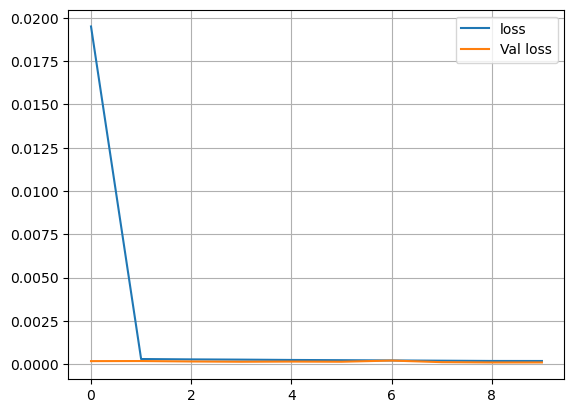

In [12]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"],label="Val loss")
plt.legend()
plt.grid()

# View some individual forecasts
Hopefully we can see that the price forecasts are reasonable. 

Again, we reverse the standard-deviation normalisation used in the data-preparation here.

In [13]:
train_std=np.array(train_std[target_columns])
train_mean=np.array(train_mean[target_columns])
for row in range(0,40,4):
    print(row,"targets",(targets_tensor_val[row,:,0]*train_std+train_mean))
    print(row,"prediction",(model(inputs_tensor_val[row:row+1]).numpy()[0,:,0]*train_std+train_mean))   

0 targets [1.06980001 1.0727     1.07340001 1.0731     1.07365    1.07425
 1.0725     1.07235001 1.07215    1.07225   ]
0 prediction [1.06532097 1.06810172 1.07113252 1.0728275  1.07321197 1.07351739
 1.07388388 1.07287695 1.07226224 1.07184312]
4 targets [1.07365    1.07425    1.0725     1.07235001 1.07215    1.07225
 1.07285    1.07315    1.07240001 1.07065   ]
4 prediction [1.07321572 1.07352001 1.07388539 1.07287804 1.07226283 1.07184334
 1.07174669 1.07211779 1.07250922 1.07223172]
8 targets [1.07215    1.07225    1.07285    1.07315    1.07240001 1.07065
 1.07080001 1.07194999 1.07265    1.07325   ]
8 prediction [1.0722661  1.07184533 1.07174782 1.07211838 1.07250954 1.07223206
 1.07099973 1.07050968 1.07102826 1.07176418]
12 targets [1.07240001 1.07065    1.07080001 1.07194999 1.07265    1.07325
 1.07255    1.07344999 1.0733     1.0736    ]
12 prediction [1.07251236 1.07223432 1.07100183 1.07051122 1.07102907 1.07176463
 1.07250918 1.07240129 1.0728653  1.07295011]
16 targets [1.

# Plot forecast graph

Let's try to show graphically the first 40 points forecast in the validation set, and compare to their targets.

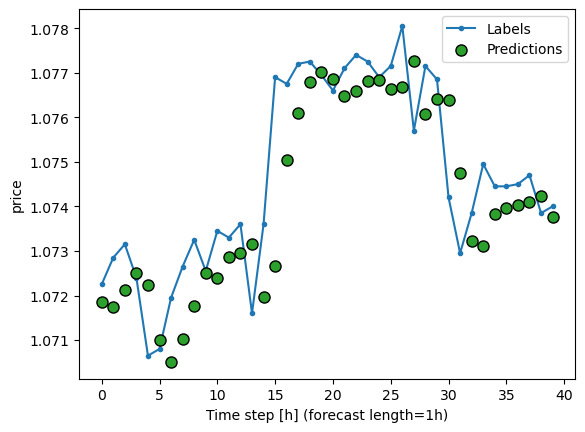

In [14]:
targets_=[]
predictions_=[]
for row in range(40):
    targets_.append(targets_tensor_val[row,-1,0]*train_std+train_mean) # here we are truncating the time series so tha only the final timestep is selected
    predictions_.append(model(inputs_tensor_val[row:row+1]).numpy()[0,-1,0]*train_std+train_mean)
plt.ylabel(train_df.columns[target_columns][0])
plt.plot(range(len(targets_)), targets_,label='Labels', marker='.', zorder=-10)
plt.scatter(range(len(predictions_)), predictions_,edgecolors='k', label='Predictions', c='#2ca02c', s=64)
plt.legend()
plt.xlabel('Time step [h] (forecast length='+str(look_ahead)+'h)')
plt.show()

## Interpreting result

This result looks reasonably good, but can you use it to actually make money?  

**Question:** If the price of AMZN stock today is 2000 dollars and 24 months ago it was 800 dollars, what magnitude would you forecast tomorrow's price to be?  2000 or 800?  Which is your personal best guess out of those two options?

What do you think the forecaster is actually doing to make its forecast?  **Can you see the problem?**

We can make this task much harder, and potentially much more useful, if we can change it to forecast the *change* of the price.  **Try this** by changing the target column to the "return" column, and retraining your network.  Then run the code on the prediction accuracy block below:

## Prediction Accuracy Check

In [ ]:
if target_columns==[1]:
    # we are forecasting the "return" column, which should be positive every time the price goes up, 
    # and negative whenever it goes down.  Let's do a sign count to see how good it is.
    # Do a sign count:
    predictions=model(inputs_tensor_val).numpy()[:,-1,0]*train_std+train_mean # calculate the final RNN prediction only (since this should be the best one having had the longest warm-up period)
    targets=targets_tensor_val[:,-1,0]*train_std+train_mean
    baseline_model=np.mean(targets) # This model just predicts the same each time - it's useful as a baseline for comparison.
    correct_predictions=(predictions*targets>0).astype(np.float32) # This will give an array of 1s and 0s showing whether each individual prediction has the correct sign or not.
    correct_baseline_predictions=(baseline_model*targets>0).astype(np.float32) # Same as above, but for baseline predictor
    print("predictions",predictions)
    print("targets",targets)
    print("correct_predictions",correct_predictions)
    print("accuracy on validation set",np.mean(correct_predictions))
    print("baserate accuracy on validation set",np.mean(correct_baseline_predictions))


## Can you improve performance at all?

- If we want the neural network to spot commonly repeating patterns in the changes of price, then we should also change the *inputs* also to be returns, not prices.  **Try this.**

- Also you can change the number of time steps the RNN gets to look at before it has to make a forecast.

- Try changing the forecast lookahead period.  
    - In this case be careful to also redefine the way returns are defined to be based upon this new look-ahead distance.

Do you have any other ideas to try yourself?

## Further work

Try to add fancier layers (e.g. dropout layers)

Add more useful inputs, e.g. other correlating stocks, sentiment information, technical "indicators" such as moving average, RSI indicator, CCI indicator, etc.

In Future work, get your own data, e.g. see https://towardsdatascience.com/time-series-and-correlations-with-stock-market-data-using-python-e66774e3a16f.  This includes sentiment data.  Also you can trawl through a wider range of commodities.

Try to pre-filter the data to remove some noise, e.g. remove unintersting moments/smooth time series and add 
stochastic noise.

Train ensemble of models.  The average of several independent models is nearly always better than any of the individual models (!).


Note that we are always fighting against the fundamental problem of market's ability to adaptation and be efficient.

### Common errors to avoid:

1. Predict changes, not absolute price.  Absolute price can be misleading.

2. Be careful about quoting results on out-of-sample data (e.g. a test set).
    - Avoid using a test set more than once to avoid survivorship bias.

3. Avoid trying to predict a stock which always moves upwards, e.g. tech stocks since 2015.

4. You can't just use the accuracy (win-rate) to rate a system. 
    - We show below how to get 90% win rates without having a good system.
    - See Andreas Krause and Michael Fairbank. "Baseline win rates for neural-network based trading algorithms." International Joint Conference on Neural Networks, Glasgow, (2020).

5. Publishing your method can make it not work:

    - Cite McLean, R. David, and Jeffrey Pontiff. "Does academic research destroy stock return predictability?." The Journal of Finance 71.1 (2016): 5-32.